In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m4-forecasting-competition-dataset/Quarterly-test.csv
/kaggle/input/m4-forecasting-competition-dataset/m4_info.csv
/kaggle/input/m4-forecasting-competition-dataset/Weekly-train.csv
/kaggle/input/m4-forecasting-competition-dataset/Hourly-train.csv
/kaggle/input/m4-forecasting-competition-dataset/Daily-train.csv
/kaggle/input/m4-forecasting-competition-dataset/Yearly-test.csv
/kaggle/input/m4-forecasting-competition-dataset/Yearly-train.csv
/kaggle/input/m4-forecasting-competition-dataset/Monthly-train.csv
/kaggle/input/m4-forecasting-competition-dataset/Weekly-test.csv
/kaggle/input/m4-forecasting-competition-dataset/Daily-test.csv
/kaggle/input/m4-forecasting-competition-dataset/Hourly-test.csv
/kaggle/input/m4-forecasting-competition-dataset/Quarterly-train.csv
/kaggle/input/m4-forecasting-competition-dataset/Monthly-test.csv


In [2]:
!pip install pmdarima prophet tensorflow==2.*

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

import pmdarima as pm
from prophet import Prophet

import tensorflow as tf
from tensorflow.keras import layers, models, backend as K


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.0 MB/s eta 0:00:00


2025-07-05 11:08:13.953000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751713694.126480      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751713694.172625      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Series Q1 length: 25


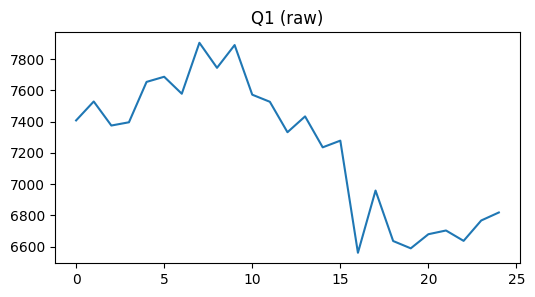

Missing count: 0


In [3]:
DATA_DIR = "/kaggle/input/m4-forecasting-competition-dataset"
train = pd.read_csv(f"{DATA_DIR}/Quarterly-train.csv")
test  = pd.read_csv(f"{DATA_DIR}/Quarterly-test.csv")
info  = pd.read_csv(f"{DATA_DIR}/m4_info.csv")

# pick the first series
series_id = train.loc[0, "V1"]
y_raw = train.loc[0, train.columns!="V1"].dropna().astype(float).values
print(f"Series {series_id} length:", len(y_raw))

# visualize
plt.figure(figsize=(6,3))
plt.plot(y_raw); plt.title(f"{series_id} (raw)"); plt.show()

# check missing
print("Missing count:", np.isnan(y_raw).sum())


In [4]:
# forward-fill then back-fill any remaining
y = pd.Series(y_raw).ffill().bfill().values
assert not np.isnan(y).any(), "Still missing!"


In [5]:
# split and leck check 
def split_series(series, val_size, test_size):
    n = len(series)
    train = series[: n - val_size - test_size]
    val   = series[n - val_size - test_size : n - test_size]
    test  = series[n - test_size :]
    return train, val, test

# last 8 quarters for val, 4 for test
y_train, y_val, y_test = split_series(y, val_size=8, test_size=4)
print(len(y_train), len(y_val), len(y_test))

# leakage check
train_idx = set(range(len(y_train)))
val_idx   = set(range(len(y_train), len(y_train)+len(y_val)))
test_idx  = set(range(len(y_train)+len(y_val), len(y)))
assert train_idx & val_idx == set()
assert train_idx & test_idx == set()
assert val_idx   & test_idx == set()
print("No leakage between splits.")


13 8 4
No leakage between splits.
